# RP modeling

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [40]:
import ocha_stratus as stratus
import pandas as pd
import matplotlib.pyplot as plt

from src.datasources import grrr, glofas
from src.utils import rp_calc

In [11]:
gf_thresh = 3130

In [8]:
df_ref_ens = pd.read_parquet(
    glofas.GF_PROC_DIR / "wuroboki_glofas_reforecast_ens.parquet"
)
df_gf_ref = (
    df_ref_ens.groupby(["valid_time", "leadtime"])["dis24"]
    .mean()
    .reset_index()
)

In [9]:
df_gf_rea = glofas.load_glofas_reanalysis(station_name="wuroboki")

In [75]:
ds_rf = grrr.load_reforecast()
df_grrr_rf = grrr.process_reforecast(ds_rf)

/Users/tdowning/OCHA/repos/ds-aa-nga-flooding/src/datasources/grrr.py:12: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


In [77]:
ds_ra = grrr.load_reanalysis()
df_grrr_ra = grrr.process_reanalysis(ds_ra)

In [14]:
ds_return_periods = grrr.load_return_periods()

In [15]:
return_periods_dict = {}

for var_name in ds_return_periods.data_vars:
    return_periods_dict[int(var_name.split("_")[-1])] = ds_return_periods[
        var_name
    ].item()

df_rp = pd.DataFrame([return_periods_dict])
df_rp = (
    df_rp.T.reset_index()
    .rename(columns={"index": "return_period", 0: "streamflow"})
    .sort_values("return_period", ascending=True)
)

In [16]:
df_rp

,return_period,streamflow
3,2,1094.202618
7,5,1352.074573
9,7,1430.030312
0,10,1507.553259
2,15,1590.985799
4,20,1647.842373
6,25,1690.852128
8,50,1819.627411
1,100,1942.872244
5,200,2062.138562


In [19]:
df_gf_rea_peaks = (
    df_gf_rea.groupby(df_gf_rea["time"].dt.year)["dis24"].max().reset_index()
)

In [28]:
df_gf_rea_peaks = rp_calc.calculate_one_group_rp(
    df_gf_rea_peaks, "dis24", ascending=False
)

In [30]:
df_gf_rea_peaks.sort_values("dis24_rank")

,time,dis24,dis24_rank,dis24_rp
9,1988,7801.156250,1,47.000000
15,1994,5575.781250,2,23.500000
43,2022,5347.171875,3,15.666667
20,1999,5244.656250,4,11.750000
6,1985,5046.875000,5,9.400000
2,1981,4933.351562,6,7.833333
45,2024,4459.265625,7,6.714286
19,1998,4300.250000,8,5.875000
8,1987,4023.500000,9,5.222222
13,1992,3635.500000,10,4.700000


In [41]:
df_gf_rea_modeled_rp = rp_calc.estimate_return_periods_from_values(
    df_gf_rea,
    date_col="time",
    val_col="dis24",
    values=df_gf_rea_peaks["dis24"],
)

In [72]:
gf_thresh_mod_rp = rp_calc.estimate_return_periods_from_values(
    df_gf_rea,
    date_col="time",
    val_col="dis24",
    values=[gf_thresh],
).iloc[0]["return_period"]

In [129]:
gf_thresh_mod_rp

2.8547918117753635

In [42]:
df_gf_rea_modeled_rp

,value,return_period
0,2392.945312,1.533061
1,3420.695312,3.827091
2,4933.351562,21.269732
3,2827.750000,2.157487
4,1910.343750,1.176009
5,1913.437500,1.177491
6,5046.875000,24.342056
7,2735.359375,1.992919
8,4023.500000,7.382880
9,7801.156250,678.705843


In [53]:
df_gf_rea_peaks = df_gf_rea_peaks.merge(
    df_gf_rea_modeled_rp.rename(
        columns={"value": "dis24", "return_period": "mod_rp"}
    )
)

In [57]:
df_gf_rea_peaks.sort_values("dis24_rank")

,time,dis24,dis24_rank,dis24_rp,mod_rp
9,1988,7801.156250,1,47.000000,678.705843
15,1994,5575.781250,2,23.500000,45.844617
43,2022,5347.171875,3,15.666667,34.843771
20,1999,5244.656250,4,11.750000,30.820406
6,1985,5046.875000,5,9.400000,24.342056
2,1981,4933.351562,6,7.833333,21.269732
45,2024,4459.265625,7,6.714286,12.176859
19,1998,4300.250000,8,5.875000,10.127233
8,1987,4023.500000,9,5.222222,7.382880
13,1992,3635.500000,10,4.700000,4.806541


(1251.937109375, 6000.0)

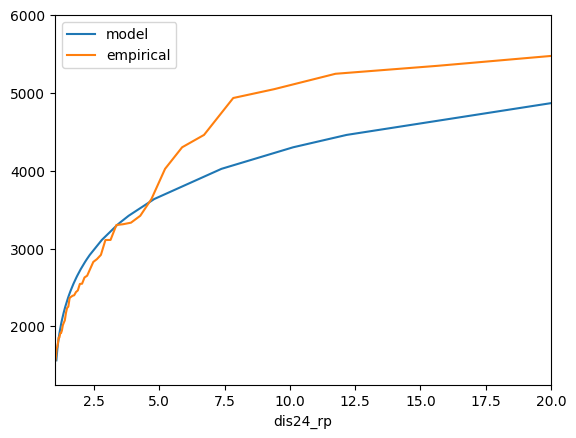

In [67]:
fig, ax = plt.subplots()

df_gf_rea_peaks.sort_values("dis24").plot(
    x="mod_rp", y="dis24", ax=ax, label="model"
)
df_gf_rea_peaks.sort_values("dis24").plot(
    x="dis24_rp", y="dis24", ax=ax, label="empirical"
)
ax.set_xlim((1, 20))
ax.set_ylim(top=6000)

In [101]:
df_grrr_rf_peaks = (
    df_grrr_rf.groupby(df_grrr_rf["valid_time"].dt.year)["streamflow"]
    .max()
    .reset_index()
)

In [102]:
df_grrr_rf_peaks

,valid_time,streamflow
0,2016,969.453369
1,2017,952.680115
2,2018,1178.059326
3,2019,1226.603638
4,2020,901.907959
5,2021,684.538391
6,2022,1899.741821
7,2023,256.455109


In [80]:
df_grrr_ra_peaks = (
    df_grrr_ra.groupby(df_grrr_ra["valid_time"].dt.year)["streamflow"]
    .max()
    .reset_index()
)

In [83]:
df_grrr_ra_peaks = rp_calc.calculate_one_group_rp(
    df_grrr_ra_peaks, col_name="streamflow", ascending=False
)

In [147]:
df_grrr_ra_peaks.sort_values("valid_time")

,valid_time,streamflow,streamflow_rank,streamflow_rp
0,1980,1559.987427,3,15.000000
1,1981,1321.095093,8,5.625000
2,1982,1260.010864,9,5.000000
3,1983,707.293579,38,1.184211
4,1984,436.359558,44,1.022727
5,1985,1247.214722,10,4.500000
6,1986,1026.430054,17,2.647059
7,1987,730.906738,37,1.216216
8,1988,1545.979370,4,11.250000
9,1989,895.918640,27,1.666667


In [96]:
grrr_trig_years = (
    df_grrr_ra_peaks[df_grrr_ra_peaks["valid_time"] >= 1998]
    .sort_values("streamflow_rank")
    .iloc[:5]["valid_time"]
    .to_list()
)

In [113]:
min_true_rf = df_grrr_rf_peaks[
    df_grrr_rf_peaks["valid_time"].isin(grrr_trig_years)
]["streamflow"].min()

In [115]:
max_false_rf = df_grrr_rf_peaks[
    ~df_grrr_rf_peaks["valid_time"].isin(grrr_trig_years)
]["streamflow"].max()

In [116]:
min_true_ra = df_grrr_ra_peaks[
    (df_grrr_ra_peaks["valid_time"] >= 1998)
    & (df_grrr_ra_peaks["valid_time"].isin(grrr_trig_years))
]["streamflow"].min()

In [117]:
max_false_ra = df_grrr_ra_peaks[
    (df_grrr_ra_peaks["valid_time"] >= 1998)
    & (~df_grrr_ra_peaks["valid_time"].isin(grrr_trig_years))
]["streamflow"].max()

In [175]:
print(min_true_rf, min_true_ra)
min_true = min(min_true_rf, min_true_ra)

1226.6036 1212.237


In [176]:
print(max_false_rf, max_false_ra)
max_false = max(max_false_rf, max_false_ra)

1178.0593 1157.0435


In [ ]:
min_true_rf, min_true_ra

In [138]:
df_gf_ref_peaks = (
    df_gf_ref.groupby([df_gf_ref["valid_time"].dt.year, "leadtime"])["dis24"]
    .max()
    .reset_index()
)

In [141]:
df_gf_rea_peaks

,time,dis24,dis24_rank,dis24_rp,mod_rp
0,1979,2392.945312,28,1.678571,1.533061
1,1980,3420.695312,11,4.272727,3.827091
2,1981,4933.351562,6,7.833333,21.269732
3,1982,2827.750000,19,2.473684,2.157487
4,1983,1910.343750,39,1.205128,1.176009
5,1984,1913.437500,38,1.236842,1.177491
6,1985,5046.875000,5,9.400000,24.342056
7,1986,2735.359375,20,2.350000,1.992919
8,1987,4023.500000,9,5.222222,7.382880
9,1988,7801.156250,1,47.000000,678.705843


In [152]:
gf_trig_years = (
    df_gf_rea_peaks[
        (df_gf_rea_peaks["time"] >= 1998) & (df_gf_rea_peaks["time"] <= 2023)
    ]
    .sort_values("dis24_rank")
    .iloc[:5]["time"]
    .to_list()
)

In [153]:
gf_trig_years

[2022, 1999, 1998, 2003, 2012]

In [160]:
df_gf_ref_peaks[
    (df_gf_ref_peaks["valid_time"].isin(gf_trig_years))
    & (df_gf_ref_peaks["leadtime"] <= 5)
]["dis24"].min()

2735.536

In [122]:
min_true, max_false

(1212.237, 1178.0593)

In [174]:
round((max_false + min_true) / 2)

1195

In [123]:
df_grrr_ra_peaks

,valid_time,streamflow,streamflow_rank,streamflow_rp
0,1980,1559.987427,3,15.000000
1,1981,1321.095093,8,5.625000
2,1982,1260.010864,9,5.000000
3,1983,707.293579,38,1.184211
4,1984,436.359558,44,1.022727
5,1985,1247.214722,10,4.500000
6,1986,1026.430054,17,2.647059
7,1987,730.906738,37,1.216216
8,1988,1545.979370,4,11.250000
9,1989,895.918640,27,1.666667


In [125]:
df_grrr_ra

,valid_time,streamflow
0,1980-01-01,79.368141
1,1980-01-02,78.400146
2,1980-01-03,77.353523
3,1980-01-04,76.434906
4,1980-01-05,75.629478
...,...,...
16058,2023-12-19,145.726746
16059,2023-12-20,144.114655
16060,2023-12-21,142.627792
16061,2023-12-22,141.002579


In [170]:
gf_thresh_mod_rps = rp_calc.estimate_return_periods_from_values(
    df_gf_rea,
    date_col="time",
    val_col="dis24",
    values=[3121, 3143],
)["return_period"]

rp_calc.estimate_return_periods(
    df_grrr_ra,
    date_col="valid_time",
    val_col="streamflow",
    target_rps=gf_thresh_mod_rps,
)

,return_period,value
0,2.829951,1061.472202
1,2.891171,1068.562234


In [168]:
rp_calc.estimate_return_periods_from_values(
    df_gf_rea,
    date_col="time",
    val_col="dis24",
    values=[3121, 3143],
)

,value,return_period
0,3121,2.829951
1,3143,2.891171


In [132]:
rp_calc.estimate_return_periods(
    df_grrr_ra,
    date_col="valid_time",
    val_col="streamflow",
)

,return_period,value
0,2,938.548157
1,3,1080.703184
2,5,1239.033221
3,7,1337.094084
4,10,1437.980479


In [178]:
df_grrr_rf["leadtime"]

,issue_time,streamflow,valid_time,leadtime
0,2016-01-01,123.154938,2016-01-01,0
1,2016-01-01,121.226303,2016-01-02,1
2,2016-01-01,120.345978,2016-01-03,2
3,2016-01-01,119.948769,2016-01-04,3
4,2016-01-01,118.302841,2016-01-05,4
...,...,...,...,...
21899,2023-06-30,223.438156,2023-07-03,3
21900,2023-06-30,232.013962,2023-07-04,4
21901,2023-06-30,236.607437,2023-07-05,5
21902,2023-06-30,239.958298,2023-07-06,6


In [183]:
df_grrr_ra.merge(df_grrr_rf[df_grrr_rf["leadtime"] == 1], on="valid_time")

,valid_time,streamflow_x,issue_time,streamflow_y,leadtime
0,2016-01-02,121.064316,2016-01-01,121.226303,1
1,2016-01-03,119.804649,2016-01-02,120.382881,1
2,2016-01-04,118.691002,2016-01-03,119.109283,1
3,2016-01-05,117.780838,2016-01-04,117.929047,1
4,2016-01-06,116.995911,2016-01-05,116.917801,1
...,...,...,...,...,...
2733,2023-06-27,187.107315,2023-06-26,185.966110,1
2734,2023-06-28,196.602264,2023-06-27,188.515564,1
2735,2023-06-29,204.994705,2023-06-28,193.516663,1
2736,2023-06-30,215.937714,2023-06-29,204.883484,1
